My idea for this project was to take the wisconsin breast cancer dataset and test the performance of multiple different machine learning models,  with the goal of trying to exceed or get as close as possible to the performance metrics reported in other papers and the UCI website which is where the dataset comes from. Since the dataset can be imported from sklearn direcetly you should be able to run this code from scratch without any problems or modifications assuming our python and library installations are similar. If you are intrested in finding out more about this data it is sourced from https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [26]:
#importing libs
from sklearn.datasets import load_breast_cancer #this loads the wisconsin dataset for breast cancer classification
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import random as ran
from sklearn.svm import SVC#only using this pre-built model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [27]:
#load data
data=load_breast_cancer()
dataframe=pd.DataFrame(data.data,columns=data.feature_names)
classdata=data.target#seperatng class data
data.target_names[0]

'malignant'

Here I will be pre-processing the data by normalizing it using z-score normalization which is one of my prefereed methods of normalizatiion due to it preserving the original information of our data while also being compatable with most computational approaches and adding a bias term of ones to the leftmost side of the data. In the last portion of the pre-processing step I also split the data to prevent overfitting and to test the models performance in an unbiased manner.

In [28]:
#Pre-process data
normdata=(dataframe-np.mean(dataframe,axis=0))/np.std(dataframe,axis=0) #using z-score normaliztion
normdata=np.array(normdata)
biasnormdata=np.c_[np.ones(normdata.shape[0]), normdata]#adding a bias term to the normalized data
#Split data
xtrain,xtest,ytrain,ytest = train_test_split(biasnormdata, classdata, test_size=0.2, random_state=42)


This is the computational meat of the project, here I am builidng multiple machine learning models from scratch, since we are working with a dataset that is relativly small I decided to use a logistic regression model optimized using gradient descent and a Naive Bayes model since both of these model typically outperform other models in similar use cases. I will also create an SVM model for comparison and benchmarking as many of my predcessors whom worked with this data have used it as a primary model.

In [29]:
warnings.filterwarnings("ignore")#ignoring some annoying pop-ups
#This the section where I create each function for the three models I will be looking at
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
#Logistic regression using gradient descent for optimization 
def logistic_regression(xtrain, xtest, ytrain, ytest):
    # Initializing thetas 
    coefs = np.random.randn(np.size(xtrain, 1) )
    # Using variables from assignment since they have broad applicability
    lr = 0.01
    maxit = 3500
    losstol = 2 ** -23
    it = 0
    while it <= maxit:
        z = np.dot(xtrain, coefs)
        preds = sigmoid(z)
        error = preds - ytrain
        gradient = np.dot(xtrain.T, error) / len(xtrain)
        coefs -= lr * gradient
        loss = -np.sum(ytrain * np.log(preds) + (1 - ytrain) * np.log(1 - preds)) / len(xtrain)
        #Termination criteria
        if it > 0 and np.abs(loss - prev_loss) / prev_loss <= losstol:
            break
        prev_loss = loss
        it += 1
    # Testing
    test_probs = sigmoid(np.dot(xtest, coefs))
    test_preds = test_probs >= 0.5
    # Finding the stats
    test_true_idx = test_preds == 1
    test_false_idx = test_preds == 0
    testtp = test_preds[test_true_idx] == ytest[test_true_idx]
    testtn = test_preds[test_false_idx] == ytest[test_false_idx]
    testfp = ~testtp
    testfn = ~testtn
    precision = np.sum(testtp) / (np.sum(testtp) + np.sum(testfp))
    recall = np.sum(testtp) / (np.sum(testtp) + np.sum(testfn))
    fmeasure = 2 * precision * recall / (precision + recall)
    accuracy = (np.sum(testtp) + np.sum(testtn)) / np.size(test_preds, 0)
    return fmeasure, accuracy, recall, precision
#Naive Bayes model
def naive_bayes(xtrain, xtest, ytrain, ytest):
    # Seperating true and false classifications
    pos_idx = ytrain == 1
    neg_idx = ~pos_idx
    pos_spam_train = xtrain[pos_idx]
    neg_spam_train = xtrain[neg_idx]
    # Finding means and standard deviations
    pos_mean_spam = np.mean(pos_spam_train, axis=0)
    pos_std_spam = np.std(pos_spam_train, axis=0, ddof=1)
    neg_mean_non = np.mean(neg_spam_train, axis=0)
    neg_std_non = np.std(neg_spam_train, axis=0, ddof=1)
    # Avoiding division by zero
    pos_std_spam[pos_std_spam == 0] = 1e-6
    neg_std_non[neg_std_non == 0] = 1e-6
    # finding priors
    prior_true = np.mean(ytrain)
    prior_false = 1 - prior_true
    # Finding likelihood
    log_like_true = -0.5 * np.sum(np.log(2 * np.pi * pos_std_spam) + ((xtest - pos_mean_spam) ** 2) / (pos_std_spam ** 2), axis=1)
    log_like_false = -0.5 * np.sum(np.log(2 * np.pi * neg_std_non) + ((xtest - neg_mean_non) ** 2) / (neg_std_non ** 2), axis=1)
    # Finding posterior probability 
    log_prob_spam = log_like_true + np.log(prior_true)
    log_prob_nonspam = log_like_false + np.log(prior_false)
    predicted_labels = (log_prob_spam > log_prob_nonspam).astype(int)
    #Performance metrics
    tp = np.sum((predicted_labels == 1) & (ytest == 1))
    tn = np.sum((predicted_labels == 0) & (ytest == 0))
    fp = np.sum((predicted_labels == 1) & (ytest == 0))
    fn = np.sum((predicted_labels == 0) & (ytest == 1))
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    fmeasure = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    accuracy = (tp + tn) / len(ytest)
    return fmeasure, accuracy, recall, precision
#SVM models are also popular in biomedical uses only having somewhat recently been supplanted by neural networks, since the wisconsin dataset is an older one many of the studies that have been conducted in the past used this model as there architecture of choice so I decided to include it in this project for comparisons sake.
def SVM(xtrain, xtest, ytrain, ytest):
    svm_model = SVC(kernel='linear')
    svm_model.fit(xtrain,ytrain)
    preds=svm_model.predict(xtest)
    #performance metrics
    tp = np.sum((preds == 1) & (ytest == 1))
    tn = np.sum((preds == 0) & (ytest == 0))
    fp = np.sum((preds == 1) & (ytest == 0))
    fn = np.sum((preds == 0) & (ytest == 1))
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    fmeasure = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    accuracy = (tp + tn) / len(ytest)
    return fmeasure, accuracy, recall, precision

Here I will be using the functions previously defined to create, train, and test each model

In [30]:
#using functions
regressionresults = []
#taking logistic regression performance metrics over ten iterations and finding the mean to account for random chance within the model
for i in range(10):
    regressionperf = logistic_regression(xtrain, xtest, ytrain, ytest)
    regressionresults.append(regressionperf)
meanregressionperf=np.mean(regressionresults,axis=0)
print('Average regression performance metrics in order of fmeasure, accurarcy, recall, and precision:',meanregressionperf)#outperforms the regression model metrics shown on the UCI site slightly  
bayesperf=naive_bayes(xtrain,xtest,ytrain,ytest)
print('Naive Bayes performance metrics in order of fmeasure, accurarcy, recall, and precision:',bayesperf)#outperforms most of the other models reported by UCI and the ones that it underperforms it does so by a potetially non-significant margin 
svmperf=SVM(xtrain,xtest,ytrain,ytest)
print('Support Vector Machine (SVM) performance metrics in order of fmeasure, accurarcy, recall, and precision:',svmperf)

Average regression performance metrics in order of fmeasure, accurarcy, recall, and precision: [0.97606317 0.97017544 0.97746479 0.97485528]
Naive Bayes performance metrics in order of fmeasure, accurarcy, recall, and precision: (0.9787234042553192, 0.9736842105263158, 0.971830985915493, 0.9857142857142858)
Support Vector Machine (SVM) performance metrics in order of fmeasure, accurarcy, recall, and precision: (0.9645390070921985, 0.956140350877193, 0.9577464788732394, 0.9714285714285714)


Lastly, in this section I will be visualizing the results of the analysis, for in-depth analysis of the results and methodologies used here, any employer is welcome to contact me in regards to the paper that was written to accompany this analysis.

357


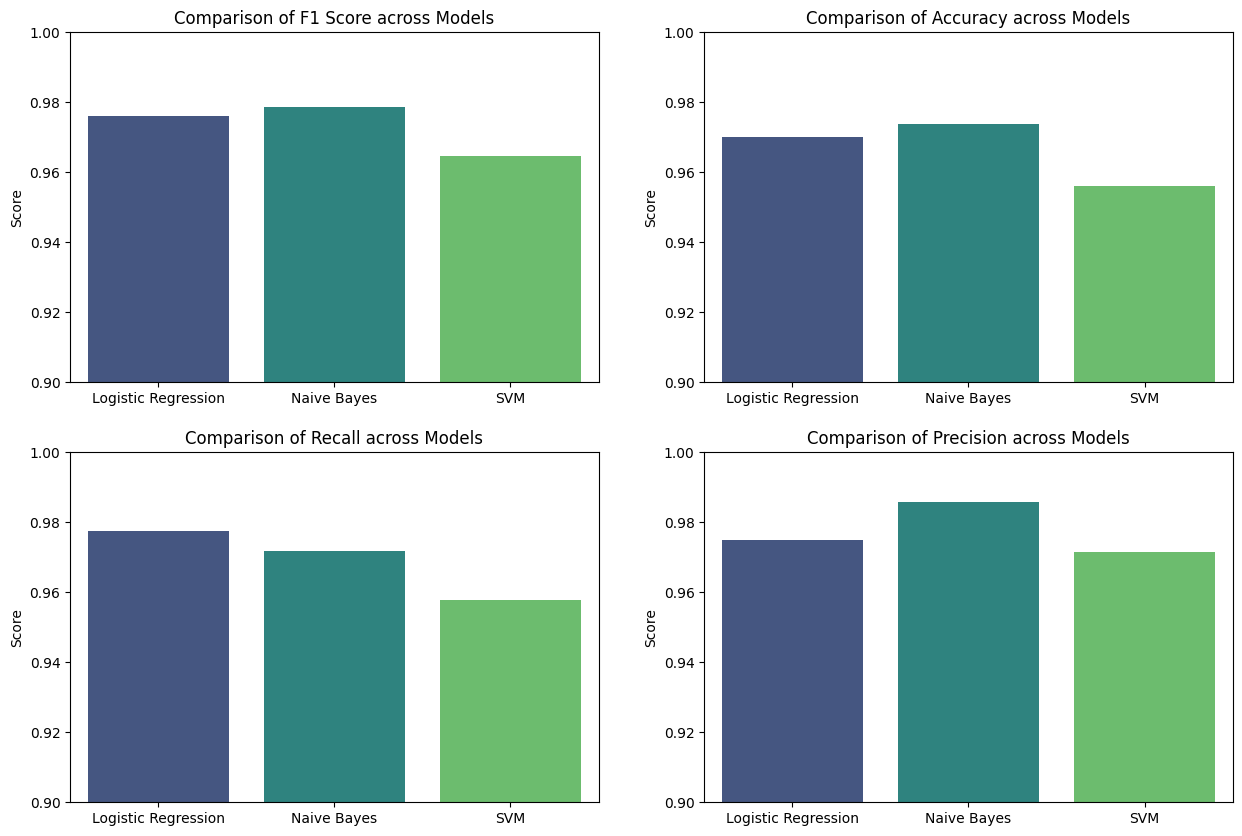

In [31]:
#extracting info for plotting
models=['Logistic Regression','Naive Bayes','SVM']
f1_scores = [meanregressionperf[0], bayesperf[0], svmperf[0]]
accuracies = [meanregressionperf[1], bayesperf[1], svmperf[1]]
recalls = [meanregressionperf[2], bayesperf[2], svmperf[2]]
precisions = [meanregressionperf[3], bayesperf[3], svmperf[3]]
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# F1 Score subplot
sns.barplot(x=models, y=f1_scores, ax=axs[0, 0],palette='viridis')
axs[0, 0].set_ylim(0.9, 1)
axs[0, 0].set_title('Comparison of F1 Score across Models')
axs[0, 0].set_ylabel('Score')
# Accuracy subplot
sns.barplot(x=models, y=accuracies, ax=axs[0, 1],palette='viridis')
axs[0, 1].set_ylim(0.9, 1)
axs[0, 1].set_title('Comparison of Accuracy across Models')
axs[0, 1].set_ylabel('Score')
# Recall subplot
sns.barplot(x=models, y=recalls, ax=axs[1, 0],palette='viridis')
axs[1, 0].set_ylim(0.9, 1)
axs[1, 0].set_title('Comparison of Recall across Models')
axs[1, 0].set_ylabel('Score')
# Precision subplot
sns.barplot(x=models, y=precisions, ax=axs[1, 1],palette='viridis')
axs[1, 1].set_ylim(0.9, 1)
axs[1, 1].set_title('Comparison of Precision across Models')
axs[1, 1].set_ylabel('Score')
print(np.sum(data.target==1))